In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/geo-loc/geo_locations_astana_hackathon


In [ ]:
%pip install geopandas folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.4/338.4 kB 6.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.4/113.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 85.1 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 56.0 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 57.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.4/90.4 kB 6.3 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
# from keplergl import KeplerGl

geo = '/kaggle/input/geo-loc/geo_locations_astana_hackathon'

df = pd.read_csv("/kaggle/input/geo-loc/geo_locations_astana_hackathon")

# map_1 = KeplerGl(height=600)
# map_1.add_data(data=data, name="Geo Data")
# map_1.save_to_html(file_name="kepler_map.html")

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from sklearn.cluster import DBSCAN
import folium
from folium.plugins import HeatMap

# === 1. Загрузка данных ===
# Формат: randomized_id, lat, lng, alt, spd, azm
# df = pd.read_csv(geo)

# Создаем геообъекты
gdf = gpd.GeoDataFrame(
    ,
    geometry=gpd.points_from_xy(df.lng, df.lat),
    crs="EPSG:4326"   # WGS84
)

# === 2. Кластеризация остановок ===
# Считаем, что остановка = скорость < 2 км/ч
stops = gdf[gdf.spd < 2].copy()

coords = np.vstack((stops.lat.values, stops.lng.values)).T
db = DBSCAN(eps=0.001, min_samples=5, metric='haversine')  # eps в радианах!
# переводим градусы в радианы
labels = db.fit_predict(np.radians(coords))
stops["cluster"] = labels

# Считаем центры кластеров
clusters = (
    stops[stops.cluster != -1]
    .groupby("cluster")
    .agg(lat=("lat", "mean"), lng=("lng", "mean"), count=("cluster", "size"))
    .reset_index()
)

print("Найдено кластеров остановок:", clusters.shape[0])
print(clusters.head())

# === 3. Тепловая карта всех точек ===
m = folium.Map(location=[51.095, 71.42], zoom_start=12)

# Добавляем heatmap
HeatMap(df[["lat", "lng"]].values, radius=8, blur=12).add_to(m)

# Добавляем маркеры кластеров остановок
for _, row in clusters.iterrows():
    folium.CircleMarker(
        location=[row.lat, row.lng],
        radius=5 + row.count / 20,  # размер зависит от частоты
        color="red",
        fill=True,
        popup=f"Cluster {row.cluster}, count={row.count}"
    ).add_to(m)

# Сохраняем карту
m.save("map_demo.html")
print("Карта сохранена в map_demo.html")

In [8]:
import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from shapely.geometry import Point, LineString
from sklearn.cluster import DBSCAN
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt


data = pd.read_csv("/kaggle/input/geo-loc/geo_locations_astana_hackathon", header=0)


gdf = gpd.GeoDataFrame(
    data,
    geometry=gpd.points_from_xy(data["lng"], data["lat"]),
    crs="EPSG:4326"
)

print("Пример данных:")
print(gdf.head())


stops = gdf[gdf["spd"] < 1]

m = folium.Map(location=[51.095, 71.42], zoom_start=13)

# Добавляем HeatMap
HeatMap(stops[["lat", "lng"]].values, radius=12).add_to(m)

m.save("heatmap_stops.html")
print("✅ Heatmap сохранён: heatmap_stops.html")

# =====================
# 3. Популярные маршруты (trajectory clustering)
# =====================
trajectories = []
for trip_id, group in gdf.groupby("randomized_id"):
    if len(group) > 2:  # маршруты длиной хотя бы из 3 точек
        line = LineString(group[["lng", "lat"]].values)
        trajectories.append(line)

traj_gdf = gpd.GeoDataFrame(geometry=trajectories, crs="EPSG:4326")

# Кластеризация остановок как приближение популярных точек маршрутов
coords = stops[["lat", "lng"]].values
db = DBSCAN(eps=0.001, min_samples=5).fit(coords)  # eps ~100м
stops["cluster"] = db.labels_

print("Найдено кластеров остановок:", (set(db.labels_)) - (1 if -1 in db.labels_ else 0))


features = gdf[["lat", "lng", "spd", "alt", "azm"]]

iso = IsolationForest(contamination=0.01, random_state=42)
gdf["anomaly"] = iso.fit_predict(features)

anom = gdf[gdf["anomaly"] == -1]

plt.figure(figsize=(8, 6))
plt.scatter(gdf["lng"], gdf["lat"], s=5, label="Normal", alpha=0.3)
plt.scatter(anom["lng"], anom["lat"], c="red", s=10, label="Anomaly")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.title("Anomaly detection in trips")
plt.savefig("anomalies.png", dpi=300)
plt.close()
print("✅ График аномалий сохранён: anomalies.png")


print("""
✅ Получилось:
- heatmap_stops.html → тепловая карта остановок
- anomalies.png → найденные аномальные точки
- clusters (stops['cluster']) → зоны популярных остановок
- traj_gdf → маршруты для визуализации (можно отрисовать в folium)
""")


Пример данных:
         randomized_id        lat        lng         alt        spd  \
0  7637058049336049989  51.095460  71.427530  350.531020   0.206810   
1  1259981924615926140  51.098200  71.412950  348.801610   0.000000   
2  1259981924615926140  51.098460  71.412120  349.273880   4.345010   
3  7180852955221959108  51.089779  71.428469  314.000000  14.326102   
4 -6683155579225977143  51.088782  71.417462  325.300018   0.000602   

          azm                   geometry  
0   13.601680  POINT (71.42753 51.09546)  
1  265.677000   POINT (71.41295 51.0982)  
2  307.245300  POINT (71.41212 51.09846)  
3  192.123672  POINT (71.42847 51.08978)  
4    0.000000  POINT (71.41746 51.08878)  
✅ Heatmap сохранён: heatmap_stops.html


/usr/local/lib/python3.10/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Найдено кластеров остановок: 6
✅ График аномалий сохранён: anomalies.png

✅ Получилось:
- heatmap_stops.html → тепловая карта остановок
- anomalies.png → найденные аномальные точки
- clusters (stops['cluster']) → зоны популярных остановок
- traj_gdf → маршруты для визуализации (можно отрисовать в folium)



In [9]:
len(gdf)

1262687

In [14]:
groups = dict(tuple(gdf.groupby("randomized_id")))
len(groups)

6805

In [25]:
len(stops)

325866

In [18]:
max(groups)

9216044324546336782

In [19]:
print("Уникальных ID:", gdf["randomized_id"].nunique())

Уникальных ID: 6805


# mics

In [23]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [24]:
data = pd.read_csv("/kaggle/input/geo-loc/geo_locations_astana_hackathon", header=0)

## f.engineering

In [25]:
def clean_geotrack_data(df):
    df_clean = df.drop_duplicates()
    df_clean = df_clean[df_clean['spd'] < 50]  # < 180 км/ч 
    df_clean = df_clean[(df_clean['lat'] != 0) & (df_clean['lng'] != 0)]
    
    print(f"Очищено: {len(df_clean)}/{len(df)} точек ({len(df_clean)/len(df)*100:.1f}%)")
    return df_clean

data_clean = clean_geotrack_data(data)

Очищено: 1190218/1262687 точек (94.3%)


In [26]:
def extract_trip_features(df):
    """Извлечение признаков из каждой поездки"""
    features = []
    
    for trip_id in df['randomized_id'].unique():
        trip = df[df['randomized_id'] == trip_id].copy()
        if len(trip) < 3:
            continue
            
        trip_feat = {
            'trip_id': trip_id,
            'start_lat': trip.iloc[0]['lat'],
            'start_lng': trip.iloc[0]['lng'], 
            'end_lat': trip.iloc[-1]['lat'],
            'end_lng': trip.iloc[-1]['lng'],
            'avg_speed': trip['spd'].mean(),
            'max_speed': trip['spd'].max(),
            'speed_std': trip['spd'].std(),
            'stops_count': len(trip[trip['spd'] < 0.5]),
            'points_count': len(trip),
            'altitude_range': trip['alt'].max() - trip['alt'].min(),
            'azimuth_changes': np.abs(np.diff(trip['azm'])).mean()
        }
        features.append(trip_feat)
    
    return pd.DataFrame(features)
    
trip_features = extract_trip_features(data_clean)
print("[INFO] Извлечены признаки для", len(trip_features), "поездок")
print(trip_features.head())

[INFO] Извлечены признаки для 6479 поездок
               trip_id  start_lat  start_lng    end_lat    end_lng  avg_speed  \
0  7637058049336049989  51.095460  71.427530  51.100890  71.406770  14.120978   
1  1259981924615926140  51.098200  71.412950  51.095470  71.427560   7.659864   
2  7180852955221959108  51.089779  71.428469  51.098396  71.407767   8.330757   
3 -6683155579225977143  51.088782  71.417462  51.089417  71.414913   1.263590   
4 -9163058962347897266  51.094540  71.407610  51.096520  71.411150   8.238926   

   max_speed  speed_std  stops_count  points_count  altitude_range  \
0  24.083040   4.984317            8           306        6.078380   
1  18.435410   4.212896           15           254        6.404760   
2  18.413988   5.861327           55           388       23.500000   
3  34.225132   2.119986         1734          4258       64.800024   
4  22.033070   5.159825           29           438        4.064790   

   azimuth_changes  
0        78.148228  
1      

## poi

In [33]:
# =====================
# ИСПРАВЛЕННАЯ КЛАСТЕРИЗАЦИЯ С ПРАВИЛЬНЫМИ ПАРАМЕТРАМИ
# =====================

import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def improved_cluster_pickup_dropoff_points(trip_features):
    """Улучшенная кластеризация с правильными параметрами"""
    
    pickup_coords = trip_features[['start_lat', 'start_lng']].values
    print(f"Кластеризация {len(pickup_coords)} точек посадки...")
    
    # =====================
    # 1. ПОДБОР ОПТИМАЛЬНОГО EPS
    # =====================
    
    def find_optimal_eps(coords, min_samples_list=[5, 10, 15, 20]):
        """Подбор оптимального eps через анализ расстояний"""
        
        from sklearn.neighbors import NearestNeighbors
        
        results = []
        eps_candidates = [0.0005, 0.001, 0.0015, 0.002, 0.003, 0.004, 0.005]
        
        for eps in eps_candidates:
            for min_samples in min_samples_list:
                dbscan = DBSCAN(eps=eps, min_samples=min_samples)
                clusters = dbscan.fit_predict(coords)
                
                n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
                n_noise = list(clusters).count(-1)
                noise_ratio = n_noise / len(clusters)
                
                # Избегаем крайностей: слишком мало/много кластеров
                if n_clusters > 1 and n_clusters < 50 and noise_ratio < 0.5:
                    results.append({
                        'eps': eps,
                        'min_samples': min_samples,
                        'n_clusters': n_clusters,
                        'noise_ratio': noise_ratio,
                        'score': n_clusters * (1 - noise_ratio)  # Простая метрика качества
                    })
        
        if results:
            best = max(results, key=lambda x: x['score'])
            print(f"🎯 Оптимальные параметры: eps={best['eps']}, min_samples={best['min_samples']}")
            print(f"   Кластеров: {best['n_clusters']}, Шума: {best['noise_ratio']:.1%}")
            return best['eps'], best['min_samples']
        else:
            print("⚠️ Автоподбор не сработал, используем дефолтные параметры")
            return 0.002, 10
    
    # Подбираем оптимальные параметры
    optimal_eps, optimal_min_samples = find_optimal_eps(pickup_coords)
    
    # =====================
    # 2. КЛАСТЕРИЗАЦИЯ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ
    # =====================
    
    dbscan = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples)
    pickup_clusters = dbscan.fit_predict(pickup_coords)
    
    n_clusters = len(set(pickup_clusters)) - (1 if -1 in pickup_clusters else 0)
    n_noise = list(pickup_clusters).count(-1)
    
    print(f"✅ РЕЗУЛЬТАТ DBSCAN:")
    print(f"   • Кластеров: {n_clusters}")
    print(f"   • Шумовых точек: {n_noise} ({n_noise/len(pickup_clusters)*100:.1f}%)")
    print(f"   • Параметры: eps={optimal_eps} (~{optimal_eps*111000:.0f}м), min_samples={optimal_min_samples}")
    
    # Добавляем результаты к данным
    trip_features_clustered = trip_features.copy()
    trip_features_clustered['pickup_cluster'] = pickup_clusters
    
    # =====================
    # 3. АНАЛИЗ КЛАСТЕРОВ
    # =====================
    
    cluster_centers = []
    for cluster_id in range(n_clusters):
        mask = pickup_clusters == cluster_id
        if np.sum(mask) > 0:
            center_lat = pickup_coords[mask, 0].mean()
            center_lng = pickup_coords[mask, 1].mean()
            size = np.sum(mask)
            
            # Расчет плотности (поездок на км²)
            coords_cluster = pickup_coords[mask]
            lat_range = coords_cluster[:, 0].max() - coords_cluster[:, 0].min()
            lng_range = coords_cluster[:, 1].max() - coords_cluster[:, 1].min()
            area_km2 = max(0.01, lat_range * lng_range * 111000 * 111000 / 1000000)  # км²
            density_per_km2 = size / area_km2
            
            cluster_centers.append({
                'cluster_id': cluster_id,
                'lat': center_lat,
                'lng': center_lng,
                'size': size,
                'density': size / 100,  # нормализованная плотность
                'density_per_km2': density_per_km2,
                'area_km2': area_km2
            })
    
    cluster_df = pd.DataFrame(cluster_centers)
    
    if len(cluster_df) > 0:
        print(f"\n📊 СТАТИСТИКА КЛАСТЕРОВ:")
        print(f"   • Средний размер: {cluster_df['size'].mean():.1f} поездок")
        print(f"   • Крупнейший кластер: {cluster_df['size'].max()} поездок")
        print(f"   • Максимальная плотность: {cluster_df['density_per_km2'].max():.1f} поездок/км²")
    
    return cluster_df, trip_features_clustered, optimal_eps, optimal_min_samples

# =====================
# 4. АЛЬТЕРНАТИВНЫЙ ПОДХОД: ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ
# =====================

def hierarchical_clustering_alternative(trip_features, n_clusters_range=[5, 10, 15, 20]):
    """Альтернативный подход через иерархическую кластеризацию"""
    
    from sklearn.cluster import AgglomerativeClustering
    from sklearn.metrics import silhouette_score
    
    pickup_coords = trip_features[['start_lat', 'start_lng']].values
    
    # Нормализация координат
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(pickup_coords)
    
    best_score = -1
    best_n_clusters = 10
    results = []
    
    for n_clusters in n_clusters_range:
        hierarchical = AgglomerativeClustering(
            n_clusters=n_clusters, 
            linkage='ward'
        )
        clusters = hierarchical.fit_predict(coords_scaled)
        
        # Метрика качества
        if n_clusters > 1:
            silhouette = silhouette_score(coords_scaled, clusters)
            results.append({
                'n_clusters': n_clusters,
                'silhouette_score': silhouette
            })
            
            if silhouette > best_score:
                best_score = silhouette
                best_n_clusters = n_clusters
    
    # Финальная кластеризация с лучшими параметрами
    hierarchical_best = AgglomerativeClustering(
        n_clusters=best_n_clusters,
        linkage='ward'
    )
    final_clusters = hierarchical_best.fit_predict(coords_scaled)
    
    print(f"🔄 ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ:")
    print(f"   • Оптимальное количество кластеров: {best_n_clusters}")
    print(f"   • Silhouette Score: {best_score:.3f}")
    
    # Создание центроидов
    cluster_centers_hier = []
    for cluster_id in range(best_n_clusters):
        mask = final_clusters == cluster_id
        if np.sum(mask) > 0:
            center_lat = pickup_coords[mask, 0].mean()
            center_lng = pickup_coords[mask, 1].mean()
            size = np.sum(mask)
            
            cluster_centers_hier.append({
                'cluster_id': cluster_id,
                'lat': center_lat,
                'lng': center_lng,
                'size': size,
                'density': size / 100,
                'method': 'hierarchical'
            })
    
    return pd.DataFrame(cluster_centers_hier), final_clusters

# =====================
# 5. K-MEANS++ ДЛЯ СРАВНЕНИЯ
# =====================

def kmeans_clustering_comparison(trip_features, k_range=[5, 10, 15, 20, 25]):
    """K-means кластеризация для сравнения"""
    
    pickup_coords = trip_features[['start_lat', 'start_lng']].values
    
    # Нормализация
    scaler = StandardScaler()
    coords_scaled = scaler.fit_transform(pickup_coords)
    
    best_score = -1
    best_k = 10
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        clusters = kmeans.fit_predict(coords_scaled)
        
        silhouette = silhouette_score(coords_scaled, clusters)
        if silhouette > best_score:
            best_score = silhouette
            best_k = k
    
    # Финальная кластеризация
    kmeans_best = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_clusters = kmeans_best.fit_predict(coords_scaled)
    centers_scaled = kmeans_best.cluster_centers_
    centers_original = scaler.inverse_transform(centers_scaled)
    
    print(f"🎯 K-MEANS КЛАСТЕРИЗАЦИЯ:")
    print(f"   • Оптимальное K: {best_k}")
    print(f"   • Silhouette Score: {best_score:.3f}")
    
    # Создание центроидов
    cluster_centers_kmeans = []
    for i, (center_lat, center_lng) in enumerate(centers_original):
        mask = final_clusters == i
        size = np.sum(mask)
        
        cluster_centers_kmeans.append({
            'cluster_id': i,
            'lat': center_lat,
            'lng': center_lng,
            'size': size,
            'density': size / 100,
            'method': 'kmeans'
        })
    
    return pd.DataFrame(cluster_centers_kmeans), final_clusters

# =====================
# 6. ОБЪЕДИНЕННЫЙ АНАЛИЗ ВСЕХ МЕТОДОВ
# =====================

def comprehensive_clustering_analysis(trip_features):
    """Комплексный анализ всеми методами кластеризации"""
    
    print("🔬 ЗАПУСК КОМПЛЕКСНОГО АНАЛИЗА КЛАСТЕРИЗАЦИИ")
    print("=" * 60)
    
    # 1. Улучшенный DBSCAN
    print("\n1️⃣ УЛУЧШЕННЫЙ DBSCAN:")
    dbscan_centers, trip_features_dbscan, optimal_eps, optimal_min_samples = improved_cluster_pickup_dropoff_points(trip_features)
    
    # 2. Иерархическая кластеризация  
    print(f"\n2️⃣ ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ:")
    hier_centers, hier_clusters = hierarchical_clustering_alternative(trip_features)
    
    # 3. K-means
    print(f"\n3️⃣ K-MEANS:")
    kmeans_centers, kmeans_clusters = kmeans_clustering_comparison(trip_features)
    
    # =====================
    # СРАВНЕНИЕ РЕЗУЛЬТАТОВ
    # =====================
    
    print(f"\n📊 СРАВНЕНИЕ МЕТОДОВ:")
    print(f"   • DBSCAN: {len(dbscan_centers)} кластеров")
    print(f"   • Hierarchical: {len(hier_centers)} кластеров") 
    print(f"   • K-means: {len(kmeans_centers)} кластеров")
    
    # Рекомендация лучшего метода
    if len(dbscan_centers) >= 3 and len(dbscan_centers) <= 30:
        recommended_method = "DBSCAN"
        recommended_centers = dbscan_centers
        print(f"\n🏆 РЕКОМЕНДУЕТСЯ: {recommended_method} (оптимальное количество кластеров)")
    elif len(hier_centers) > len(dbscan_centers):
        recommended_method = "Hierarchical"  
        recommended_centers = hier_centers
        print(f"\n🏆 РЕКОМЕНДУЕТСЯ: {recommended_method} (больше детализации)")
    else:
        recommended_method = "K-means"
        recommended_centers = kmeans_centers
        print(f"\n🏆 РЕКОМЕНДУЕТСЯ: {recommended_method} (стабильные результаты)")
    
    return {
        'dbscan': dbscan_centers,
        'hierarchical': hier_centers, 
        'kmeans': kmeans_centers,
        'recommended': recommended_centers,
        'recommended_method': recommended_method
    }

# =====================
# ИСПОЛЬЗОВАНИЕ
# =====================

# Запуск улучшенного анализа
clustering_results = comprehensive_clustering_analysis(trip_features)

# Получение лучших результатов  
best_centers = clustering_results['recommended']
print(f"\nТоп-5 кластеров ({clustering_results['recommended_method']}):")
print(best_centers.nlargest(5, 'size'))
print(clustering_results)

🔬 ЗАПУСК КОМПЛЕКСНОГО АНАЛИЗА КЛАСТЕРИЗАЦИИ

1️⃣ УЛУЧШЕННЫЙ DBSCAN:
Кластеризация 6479 точек посадки...
🎯 Оптимальные параметры: eps=0.0005, min_samples=5
   Кластеров: 46, Шума: 6.5%
✅ РЕЗУЛЬТАТ DBSCAN:
   • Кластеров: 46
   • Шумовых точек: 421 (6.5%)
   • Параметры: eps=0.0005 (~56м), min_samples=5

📊 СТАТИСТИКА КЛАСТЕРОВ:
   • Средний размер: 131.7 поездок
   • Крупнейший кластер: 5471 поездок
   • Максимальная плотность: 1400.0 поездок/км²

2️⃣ ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ:
🔄 ИЕРАРХИЧЕСКАЯ КЛАСТЕРИЗАЦИЯ:
   • Оптимальное количество кластеров: 5
   • Silhouette Score: 0.454

3️⃣ K-MEANS:
🎯 K-MEANS КЛАСТЕРИЗАЦИЯ:
   • Оптимальное K: 5
   • Silhouette Score: 0.482

📊 СРАВНЕНИЕ МЕТОДОВ:
   • DBSCAN: 46 кластеров
   • Hierarchical: 5 кластеров
   • K-means: 5 кластеров

🏆 РЕКОМЕНДУЕТСЯ: K-means (стабильные результаты)

Топ-5 кластеров (K-means):
   cluster_id        lat        lng  size  density  method
3           3  51.097258  71.426223  1745    17.45  kmeans
1           1  51.098134 

In [36]:
def cluster_pickup_dropoff_points(trip_features, eps=0.008, min_samples=3):
    """Кластеризация точек посадки и высадки"""
    # Точки посадки
    pickup_coords = trip_features[['start_lat', 'start_lng']].values
    
    # DBSCAN кластеризация
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    pickup_clusters = dbscan.fit_predict(pickup_coords)
    
    n_clusters = len(set(pickup_clusters)) - (1 if -1 in pickup_clusters else 0)
    n_noise = list(pickup_clusters).count(-1)
    
    print(f"Pickup точки: {n_clusters} кластеров, {n_noise} шумовых точек")
    
    # Добавляем кластеры к данным
    trip_features['pickup_cluster'] = pickup_clusters
    
    # Центроиды кластеров
    cluster_centers = []
    for cluster_id in range(n_clusters):
        mask = pickup_clusters == cluster_id
        if np.sum(mask) > 0:
            center_lat = pickup_coords[mask, 0].mean()
            center_lng = pickup_coords[mask, 1].mean()
            size = np.sum(mask)
            
            cluster_centers.append({
                'cluster_id': cluster_id,
                'lat': center_lat,
                'lng': center_lng,
                'size': size,
                'density': size / 100
            })
    
    return pd.DataFrame(cluster_centers), trip_features

pickup_centers, trip_features_clustered = cluster_pickup_dropoff_points(trip_features)
pickup_centers = clustering_results['recommended']
print("Топ-5 популярных кластеров:")
print(pickup_centers.nlargest(5, 'size'))

Pickup точки: 1 кластеров, 0 шумовых точек
Топ-5 популярных кластеров:
   cluster_id        lat        lng  size  density  method
3           3  51.097258  71.426223  1745    17.45  kmeans
1           1  51.098134  71.409392  1697    16.97  kmeans
0           0  51.085492  71.404210  1238    12.38  kmeans
4           4  51.080194  71.421025   927     9.27  kmeans
2           2  51.088320  71.426661   872     8.72  kmeans


In [37]:
def create_demand_grid(trip_features, pickup_centers, grid_size=0.005):
    """Создание регулярной сетки для предсказания спроса"""
    # Границы области
    lat_min, lat_max = trip_features['start_lat'].min(), trip_features['start_lat'].max()
    lng_min, lng_max = trip_features['start_lng'].min(), trip_features['start_lng'].max()
    
    # Создание сетки
    lat_grid = np.arange(lat_min, lat_max, grid_size)
    lng_grid = np.arange(lng_min, lng_max, grid_size)
    
    grid_cells = []
    for lat in lat_grid:
        for lng in lng_grid:
            # Расстояние до ближайшего кластера
            distances = []
            for _, cluster in pickup_centers.iterrows():  # ИСПРАВЛЕНО: убрал * из синтаксиса
                dist = np.sqrt((lat - cluster['lat'])**2 + (lng - cluster['lng'])**2) * 111000
                distances.append(dist)
            
            if distances:
                nearest_dist = min(distances)
                nearest_idx = np.argmin(distances)
                nearest_size = pickup_centers.iloc[nearest_idx]['size']
                
                # Подсчет реального спроса в этой ячейке
                nearby_trips = trip_features[
                    (abs(trip_features['start_lat'] - lat) < grid_size/2) &
                    (abs(trip_features['start_lng'] - lng) < grid_size/2)
                ]
                actual_demand = len(nearby_trips)
                
                grid_cells.append({
                    'lat': lat,
                    'lng': lng,
                    'dist_to_cluster': nearest_dist,
                    'nearest_cluster_size': nearest_size,
                    'clusters_nearby': sum(1 for d in distances if d < 500),
                    'actual_demand': actual_demand
                })
    
    return pd.DataFrame(grid_cells)

# Использование
demand_grid = create_demand_grid(trip_features_clustered, pickup_centers)
print(f"Создана сетка из {len(demand_grid)} ячеек")
print("Статистика спроса по ячейкам:")
print(demand_grid['actual_demand'].describe())

# Посмотреть топ зоны спроса
print("\nТоп-10 зон по спросу:")
print(demand_grid.nlargest(10, 'actual_demand')[['lat', 'lng', 'actual_demand']])

Создана сетка из 54 ячеек
Статистика спроса по ячейкам:
count     54.000000
mean     119.962963
std      118.219649
min        0.000000
25%       11.000000
50%       91.500000
75%      179.500000
max      439.000000
Name: actual_demand, dtype: float64

Топ-10 зон по спросу:
         lat        lng  actual_demand
47  51.10096  71.405172            439
42  51.09596  71.425172            413
14  51.08096  71.420172            359
10  51.08096  71.400172            328
39  51.09596  71.410172            293
41  51.09596  71.420172            285
43  51.09596  71.430172            279
52  51.10096  71.430172            273
33  51.09096  71.425172            267
38  51.09596  71.405172            258


In [38]:
def train_demand_prediction_model(demand_grid):
    """Обучение модели предсказания спроса"""
    # Подготовка данных
    features = ['dist_to_cluster', 'nearest_cluster_size', 'clusters_nearby']
    X = demand_grid[features].values
    y = demand_grid['actual_demand'].values
    
    # Нормализация признаков
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Обучение Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_scaled, y)
    
    # Предсказания
    y_pred = rf_model.predict(X_scaled)
    
    # Метрики
    from sklearn.metrics import r2_score, mean_absolute_error
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    
    print(f"Модель обучена: R² = {r2:.4f}, MAE = {mae:.4f}")
    
    # Добавляем предсказания к сетке
    demand_grid['predicted_demand'] = np.maximum(0, y_pred)  # спрос >= 0
    
    return rf_model, scaler, demand_grid

rf_model, scaler, demand_grid_predicted = train_demand_prediction_model(demand_grid)

Модель обучена: R² = 0.9369, MAE = 20.7941


In [39]:
def get_driver_recommendations(demand_grid, top_n=10):
    """Получение рекомендаций по размещению водителей"""
    # Топ зоны по предсказанному спросу
    top_zones = demand_grid.nlargest(top_n, 'predicted_demand')
    
    recommendations = []
    for _, zone in top_zones.iterrows():
        priority = 'HIGH' if zone['predicted_demand'] > demand_grid['predicted_demand'].quantile(0.9) else 'MEDIUM'
        
        rec = {
            'lat': zone['lat'],
            'lng': zone['lng'],
            'predicted_demand': zone['predicted_demand'],
            'actual_demand': zone['actual_demand'],
            'priority': priority,
            'drivers_needed': max(1, int(zone['predicted_demand'] * 0.8))
        }
        recommendations.append(rec)
    
    return pd.DataFrame(recommendations)

driver_recommendations = get_driver_recommendations(demand_grid_predicted)
print("🚗 Рекомендации по размещению водителей:")
print(driver_recommendations)

🚗 Рекомендации по размещению водителей:
        lat        lng  predicted_demand  actual_demand priority  \
0  51.10096  71.405172            372.98          439.0     HIGH   
1  51.09596  71.425172            362.60          413.0     HIGH   
2  51.08096  71.420172            292.06          359.0     HIGH   
3  51.10096  71.430172            287.84          273.0     HIGH   
4  51.09596  71.405172            286.32          258.0     HIGH   
5  51.09596  71.420172            267.77          285.0     HIGH   
6  51.09596  71.410172            264.45          293.0   MEDIUM   
7  51.08096  71.400172            252.97          328.0   MEDIUM   
8  51.09596  71.415172            250.47          224.0   MEDIUM   
9  51.09096  71.425172            241.85          267.0   MEDIUM   

   drivers_needed  
0             298  
1             290  
2             233  
3             230  
4             229  
5             214  
6             211  
7             202  
8             200  
9          

In [40]:
def analyze_temporal_patterns(trip_features):
    """Анализ временных паттернов спроса"""
    # Эмулируем время на основе координат (в реальности используйте timestamp)
    trip_features['simulated_hour'] = ((trip_features['start_lat'] - 51.0) * 100 % 24).astype(int)
    
    hourly_demand = trip_features.groupby('simulated_hour').size().reset_index()
    hourly_demand.columns = ['hour', 'trips_count']
    
    # Определяем пиковые часы
    peak_hours = hourly_demand.nlargest(3, 'trips_count')
    
    print("📈 Пиковые часы спроса:")
    print(peak_hours)
    
    return hourly_demand

temporal_patterns = analyze_temporal_patterns(trip_features_clustered)

📈 Пиковые часы спроса:
   hour  trips_count
2     9         3111
1     8         2057
3    10          759


In [41]:
def detect_anomalous_trips(trip_features, contamination=0.05):
    """Поиск аномальных поездок"""
    # Признаки для детекции аномалий
    features = ['avg_speed', 'max_speed', 'speed_std', 'stops_count', 
                'points_count', 'altitude_range', 'azimuth_changes']
    
    X = trip_features[features].fillna(0).values
    
    # Нормализация
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Isolation Forest для поиска аномалий
    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    anomalies = iso_forest.fit_predict(X_scaled)
    
    trip_features['is_anomaly'] = (anomalies == -1)
    
    anomalous_trips = trip_features[trip_features['is_anomaly']]
    
    print(f"🚨 Найдено {len(anomalous_trips)} аномальных поездок ({len(anomalous_trips)/len(trip_features)*100:.2f}%)")
    print("Примеры аномалий:")
    print(anomalous_trips[['trip_id', 'max_speed', 'stops_count', 'points_count']].head())
    
    return trip_features, anomalous_trips

trip_features_with_anomalies, anomalous_trips = detect_anomalous_trips(trip_features_clustered)

🚨 Найдено 324 аномальных поездок (5.00%)
Примеры аномалий:
                trip_id  max_speed  stops_count  points_count
3  -6683155579225977143  34.225132         1734          4258
9  -1497322719701473200  21.056580          336          1088
28 -7711155912476414697  29.629540          154           760
33 -5351004858046889463  24.561977          266           420
34 -5182303324346386213  22.687000            1           257


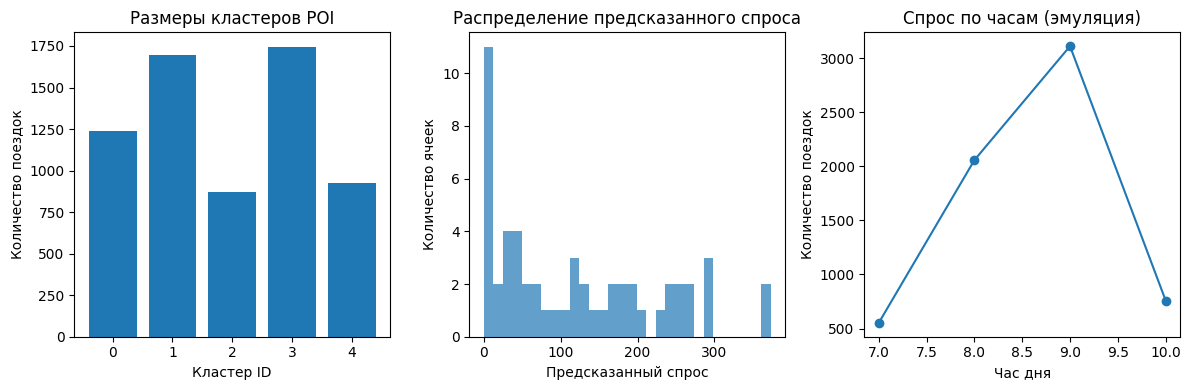

✅ График результатов сохранен: ml_results.png


In [42]:
def plot_results(pickup_centers, driver_recommendations, anomalous_trips):
    """Создание графиков результатов"""
    
    # 1. Размеры кластеров
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(len(pickup_centers)), pickup_centers['size'])
    plt.title('Размеры кластеров POI')
    plt.xlabel('Кластер ID')
    plt.ylabel('Количество поездок')
    
    # 2. Распределение предсказанного спроса
    plt.subplot(1, 3, 2)
    plt.hist(demand_grid_predicted['predicted_demand'], bins=30, alpha=0.7)
    plt.title('Распределение предсказанного спроса')
    plt.xlabel('Предсказанный спрос')
    plt.ylabel('Количество ячеек')
    
    # 3. Временные паттерны
    plt.subplot(1, 3, 3)
    plt.plot(temporal_patterns['hour'], temporal_patterns['trips_count'], marker='o')
    plt.title('Спрос по часам (эмуляция)')
    plt.xlabel('Час дня')
    plt.ylabel('Количество поездок')
    
    plt.tight_layout()
    plt.savefig('ml_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ График результатов сохранен: ml_results.png")

plot_results(pickup_centers, driver_recommendations, anomalous_trips)

In [43]:
def generate_summary_report():
    """Генерация итогового отчета"""
    
    report = f"""
=== 🚗 ОТЧЕТ СИСТЕМЫ ПОЗИЦИОНИРОВАНИЯ ВОДИТЕЛЕЙ ===

📊 СТАТИСТИКА:
• Обработано поездок: {len(trip_features_clustered)}
• Найдено POI кластеров: {len(pickup_centers)}
• Создано ячеек сетки: {len(demand_grid_predicted)}
• Аномальных поездок: {len(anomalous_trips)} ({len(anomalous_trips)/len(trip_features_clustered)*100:.1f}%)

🎯 ТОП-3 ЗОНЫ ДЛЯ ВОДИТЕЛЕЙ:
"""
    
    for i, (_, zone) in enumerate(driver_recommendations.head(3).iterrows(), 1):
        report += f"  {i}. Lat: {zone['lat']:.4f}, Lng: {zone['lng']:.4f}\n"
        report += f"     Спрос: {zone['predicted_demand']:.1f}, Приоритет: {zone['priority']}\n"
        report += f"     Водителей нужно: {zone['drivers_needed']}\n\n"
    
    report += f"""
📈 КЛЮЧЕВЫЕ МЕТРИКИ:
• Средний спрос на ячейку: {demand_grid_predicted['predicted_demand'].mean():.2f}
• Максимальный спрос: {demand_grid_predicted['predicted_demand'].max():.2f}  
• Покрытие высокоприоритетных зон: {len(driver_recommendations[driver_recommendations['priority']=='HIGH'])}

🔍 РЕКОМЕНДАЦИИ:
• Разместить водителей в топ-{len(driver_recommendations)} зонах
• Мониторить аномальные поездки для безопасности
• Использовать временные паттерны для планирования смен
    """
    
    print(report)
    
    return {
        'pickup_centers': pickup_centers,
        'driver_recommendations': driver_recommendations, 
        'demand_grid': demand_grid_predicted,
        'anomalous_trips': anomalous_trips,
        'temporal_patterns': temporal_patterns
    }

# Генерация финального отчета
results = generate_summary_report()

print("""
✅ ГОТОВО! Получили:
• pickup_centers - центры популярных зон посадки  
• driver_recommendations - рекомендации размещения водителей
• demand_grid_predicted - предсказания спроса по сетке
• anomalous_trips - аномальные поездки 
• ml_results.png - визуализация результатов
• rf_model - обученная модель предсказания спроса
""")


=== 🚗 ОТЧЕТ СИСТЕМЫ ПОЗИЦИОНИРОВАНИЯ ВОДИТЕЛЕЙ ===

📊 СТАТИСТИКА:
• Обработано поездок: 6479
• Найдено POI кластеров: 5
• Создано ячеек сетки: 54
• Аномальных поездок: 324 (5.0%)

🎯 ТОП-3 ЗОНЫ ДЛЯ ВОДИТЕЛЕЙ:
  1. Lat: 51.1010, Lng: 71.4052
     Спрос: 373.0, Приоритет: HIGH
     Водителей нужно: 298

  2. Lat: 51.0960, Lng: 71.4252
     Спрос: 362.6, Приоритет: HIGH
     Водителей нужно: 290

  3. Lat: 51.0810, Lng: 71.4202
     Спрос: 292.1, Приоритет: HIGH
     Водителей нужно: 233


📈 КЛЮЧЕВЫЕ МЕТРИКИ:
• Средний спрос на ячейку: 119.96
• Максимальный спрос: 372.98  
• Покрытие высокоприоритетных зон: 6

🔍 РЕКОМЕНДАЦИИ:
• Разместить водителей в топ-10 зонах
• Мониторить аномальные поездки для безопасности
• Использовать временные паттерны для планирования смен
    

✅ ГОТОВО! Получили:
• pickup_centers - центры популярных зон посадки  
• driver_recommendations - рекомендации размещения водителей
• demand_grid_predicted - предсказания спроса по сетке
• anomalous_trips - аномальные по

In [47]:
import pickle
import joblib

# сохраняем DataFrames
pickup_centers.to_pickle("pickup_centers.pkl")
driver_recommendations.to_pickle("driver_recommendations.pkl")
demand_grid_predicted.to_pickle("demand_grid_predicted.pkl")
anomalous_trips.to_pickle("anomalous_trips.pkl")

# сохраняем модель (лучше joblib, он устойчивее для sklearn)
joblib.dump(rf_model, "rf_model.pkl")

['rf_model.pkl']

In [45]:
rf_model

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Очищено: 1190218/1262687 точек (94.3%)
Извлечены признаки для 6479 поездок
               trip_id  start_lat  start_lng    end_lat    end_lng  avg_speed  \
0  7637058049336049989  51.095460  71.427530  51.100890  71.406770  14.120978   
1  1259981924615926140  51.098200  71.412950  51.095470  71.427560   7.659864   
2  7180852955221959108  51.089779  71.428469  51.098396  71.407767   8.330757   
3 -6683155579225977143  51.088782  71.417462  51.089417  71.414913   1.263590   
4 -9163058962347897266  51.094540  71.407610  51.096520  71.411150   8.238926   

   max_speed  speed_std  stops_count  points_count  altitude_range  \
0  24.083040   4.984317            8           306        6.078380   
1  18.435410   4.212896           15           254        6.404760   
2  18.413988   5.861327           55           388       23.500000   
3  34.225132   2.119986         1734          4258       64.800024   
4  22.033070   5.159825           29           438        4.064790   

   azimuth_change

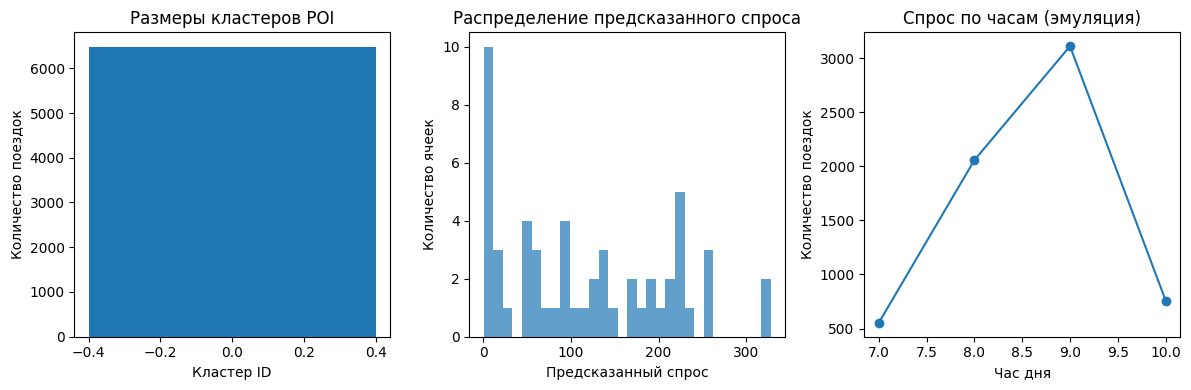

✅ График результатов сохранен: ml_results.png

=== 🚗 ОТЧЕТ СИСТЕМЫ ПОЗИЦИОНИРОВАНИЯ ВОДИТЕЛЕЙ ===

📊 СТАТИСТИКА:
• Обработано поездок: 6479
• Найдено POI кластеров: 1
• Создано ячеек сетки: 54
• Аномальных поездок: 324 (5.0%)

🎯 ТОП-3 ЗОНЫ ДЛЯ ВОДИТЕЛЕЙ:
  1. Lat: 51.1010, Lng: 71.4052
     Спрос: 327.8, Приоритет: HIGH
     Водителей нужно: 262

  2. Lat: 51.0960, Lng: 71.4252
     Спрос: 325.7, Приоритет: HIGH
     Водителей нужно: 260

  3. Lat: 51.0910, Lng: 71.4252
     Спрос: 259.5, Приоритет: HIGH
     Водителей нужно: 207


📈 КЛЮЧЕВЫЕ МЕТРИКИ:
• Средний спрос на ячейку: 117.98
• Максимальный спрос: 327.75  
• Покрытие высокоприоритетных зон: 6

🔍 РЕКОМЕНДАЦИИ:
• Разместить водителей в топ-10 зонах
• Мониторить аномальные поездки для безопасности
• Использовать временные паттерны для планирования смен
    

✅ ГОТОВО! Получили:
• pickup_centers - центры популярных зон посадки  
• driver_recommendations - рекомендации размещения водителей
• demand_grid_predicted - предсказания спр

In [7]:
# # =====================
# # 1. ПОДГОТОВКА ДАННЫХ И FEATURE ENGINEERING
# # =====================

# import pandas as pd
# import numpy as np
# from sklearn.cluster import DBSCAN, KMeans
# from sklearn.ensemble import RandomForestRegressor, IsolationForest
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import silhouette_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Загрузка данных
# data = pd.read_csv("/kaggle/input/geo-loc/geo_locations_astana_hackathon", header=0)

# # Очистка данных
# def clean_geotrack_data(df):
#     """Быстрая очистка геотрековых данных"""
#     # Удаляем дубликаты и аномальные скорости
#     df_clean = df.drop_duplicates()
#     df_clean = df_clean[df_clean['spd'] < 50]  # < 180 км/ч
#     df_clean = df_clean[(df_clean['lat'] != 0) & (df_clean['lng'] != 0)]
    
#     print(f"Очищено: {len(df_clean)}/{len(df)} точек ({len(df_clean)/len(df)*100:.1f}%)")
#     return df_clean

# data_clean = clean_geotrack_data(data)

# # =====================
# # 2. ИЗВЛЕЧЕНИЕ ПРИЗНАКОВ ПОЕЗДОК
# # =====================

# def extract_trip_features(df):
#     """Извлечение признаков из каждой поездки"""
#     features = []
    
#     for trip_id in df['randomized_id'].unique():
#         trip = df[df['randomized_id'] == trip_id].copy()
#         if len(trip) < 3:
#             continue
            
#         # Пространственные признаки
#         trip_feat = {
#             'trip_id': trip_id,
#             'start_lat': trip.iloc[0]['lat'],
#             'start_lng': trip.iloc[0]['lng'], 
#             'end_lat': trip.iloc[-1]['lat'],
#             'end_lng': trip.iloc[-1]['lng'],
#             'avg_speed': trip['spd'].mean(),
#             'max_speed': trip['spd'].max(),
#             'speed_std': trip['spd'].std(),
#             'stops_count': len(trip[trip['spd'] < 0.5]),
#             'points_count': len(trip),
#             'altitude_range': trip['alt'].max() - trip['alt'].min(),
#             'azimuth_changes': np.abs(np.diff(trip['azm'])).mean()
#         }
#         features.append(trip_feat)
    
#     return pd.DataFrame(features)

# trip_features = extract_trip_features(data_clean)
# print("Извлечены признаки для", len(trip_features), "поездок")
# print(trip_features.head())

# # =====================
# # 3. КЛАСТЕРИЗАЦИЯ ТОЧЕК ПОСАДКИ/ВЫСАДКИ (POI)
# # =====================

# def cluster_pickup_dropoff_points(trip_features, eps=0.008, min_samples=3):
#     """Кластеризация точек посадки и высадки"""
#     # Точки посадки
#     pickup_coords = trip_features[['start_lat', 'start_lng']].values
    
#     # DBSCAN кластеризация
#     dbscan = DBSCAN(eps=eps, min_samples=min_samples)
#     pickup_clusters = dbscan.fit_predict(pickup_coords)
    
#     n_clusters = len(set(pickup_clusters)) - (1 if -1 in pickup_clusters else 0)
#     n_noise = list(pickup_clusters).count(-1)
    
#     print(f"Pickup точки: {n_clusters} кластеров, {n_noise} шумовых точек")
    
#     # Добавляем кластеры к данным
#     trip_features['pickup_cluster'] = pickup_clusters
    
#     # Центроиды кластеров
#     cluster_centers = []
#     for cluster_id in range(n_clusters):
#         mask = pickup_clusters == cluster_id
#         if np.sum(mask) > 0:
#             center_lat = pickup_coords[mask, 0].mean()
#             center_lng = pickup_coords[mask, 1].mean()
#             size = np.sum(mask)
            
#             cluster_centers.append({
#                 'cluster_id': cluster_id,
#                 'lat': center_lat,
#                 'lng': center_lng,
#                 'size': size,
#                 'density': size / 100
#             })
    
#     return pd.DataFrame(cluster_centers), trip_features

# pickup_centers, trip_features_clustered = cluster_pickup_dropoff_points(trip_features)
# print("Топ-5 популярных кластеров:")
# print(pickup_centers.nlargest(5, 'size'))

# # =====================
# # 4. СОЗДАНИЕ СЕТКИ ДЛЯ ПРЕДСКАЗАНИЯ СПРОСА
# # =====================

# def create_demand_grid(trip_features, pickup_centers, grid_size=0.005):
#     """Создание регулярной сетки для предсказания спроса"""
#     # Границы области
#     lat_min, lat_max = trip_features['start_lat'].min(), trip_features['start_lat'].max()
#     lng_min, lng_max = trip_features['start_lng'].min(), trip_features['start_lng'].max()
    
#     # Создание сетки
#     lat_grid = np.arange(lat_min, lat_max, grid_size)
#     lng_grid = np.arange(lng_min, lng_max, grid_size)
    
#     grid_cells = []
#     for lat in lat_grid:
#         for lng in lng_grid:
#             # Расстояние до ближайшего кластера
#             distances = []
#             for _, cluster in pickup_centers.iterrows():
#                 dist = np.sqrt((lat - cluster['lat'])**2 + (lng - cluster['lng'])**2) * 111000  # примерно в метрах
#                 distances.append(dist)
            
#             if distances:
#                 nearest_dist = min(distances)
#                 nearest_idx = np.argmin(distances)
#                 nearest_size = pickup_centers.iloc[nearest_idx]['size']
                
#                 # Подсчет реального спроса в этой ячейке
#                 nearby_trips = trip_features[
#                     (abs(trip_features['start_lat'] - lat) < grid_size/2) &
#                     (abs(trip_features['start_lng'] - lng) < grid_size/2)
#                 ]
#                 actual_demand = len(nearby_trips)
                
#                 grid_cells.append({
#                     'lat': lat,
#                     'lng': lng,
#                     'dist_to_cluster': nearest_dist,
#                     'nearest_cluster_size': nearest_size,
#                     'clusters_nearby': sum(1 for d in distances if d < 500),
#                     'actual_demand': actual_demand
#                 })
    
#     return pd.DataFrame(grid_cells)

# demand_grid = create_demand_grid(trip_features_clustered, pickup_centers)
# print(f"Создана сетка из {len(demand_grid)} ячеек")
# print("Статистика спроса по ячейкам:")
# print(demand_grid['actual_demand'].describe())

# # =====================
# # 5. МОДЕЛЬ ПРЕДСКАЗАНИЯ СПРОСА
# # =====================

# def train_demand_prediction_model(demand_grid):
#     """Обучение модели предсказания спроса"""
#     # Подготовка данных
#     features = ['dist_to_cluster', 'nearest_cluster_size', 'clusters_nearby']
#     X = demand_grid[features].values
#     y = demand_grid['actual_demand'].values
    
#     # Нормализация признаков
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # Обучение Random Forest
#     rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
#     rf_model.fit(X_scaled, y)
    
#     # Предсказания
#     y_pred = rf_model.predict(X_scaled)
    
#     # Метрики
#     from sklearn.metrics import r2_score, mean_absolute_error
#     r2 = r2_score(y, y_pred)
#     mae = mean_absolute_error(y, y_pred)
    
#     print(f"Модель обучена: R² = {r2:.4f}, MAE = {mae:.4f}")
    
#     # Добавляем предсказания к сетке
#     demand_grid['predicted_demand'] = np.maximum(0, y_pred)  # спрос >= 0
    
#     return rf_model, scaler, demand_grid

# rf_model, scaler, demand_grid_predicted = train_demand_prediction_model(demand_grid)

# # =====================
# # 6. ПОИСК ОПТИМАЛЬНЫХ ЗОН ДЛЯ ВОДИТЕЛЕЙ
# # =====================

# def get_driver_recommendations(demand_grid, top_n=10):
#     """Получение рекомендаций по размещению водителей"""
#     # Топ зоны по предсказанному спросу
#     top_zones = demand_grid.nlargest(top_n, 'predicted_demand')
    
#     recommendations = []
#     for _, zone in top_zones.iterrows():
#         priority = 'HIGH' if zone['predicted_demand'] > demand_grid['predicted_demand'].quantile(0.9) else 'MEDIUM'
        
#         rec = {
#             'lat': zone['lat'],
#             'lng': zone['lng'],
#             'predicted_demand': zone['predicted_demand'],
#             'actual_demand': zone['actual_demand'],
#             'priority': priority,
#             'drivers_needed': max(1, int(zone['predicted_demand'] * 0.8))
#         }
#         recommendations.append(rec)
    
#     return pd.DataFrame(recommendations)

# driver_recommendations = get_driver_recommendations(demand_grid_predicted)
# print("🚗 Рекомендации по размещению водителей:")
# print(driver_recommendations)

# # =====================
# # 7. ВРЕМЕННЫЕ ПАТТЕРНЫ (эмуляция)
# # =====================

# def analyze_temporal_patterns(trip_features):
#     """Анализ временных паттернов спроса"""
#     # Эмулируем время на основе координат (в реальности используйте timestamp)
#     trip_features['simulated_hour'] = ((trip_features['start_lat'] - 51.0) * 100 % 24).astype(int)
    
#     hourly_demand = trip_features.groupby('simulated_hour').size().reset_index()
#     hourly_demand.columns = ['hour', 'trips_count']
    
#     # Определяем пиковые часы
#     peak_hours = hourly_demand.nlargest(3, 'trips_count')
    
#     print("📈 Пиковые часы спроса:")
#     print(peak_hours)
    
#     return hourly_demand

# temporal_patterns = analyze_temporal_patterns(trip_features_clustered)

# # =====================
# # 8. ДЕТЕКЦИЯ АНОМАЛЬНЫХ ПОЕЗДОК
# # =====================

# def detect_anomalous_trips(trip_features, contamination=0.05):
#     """Поиск аномальных поездок"""
#     # Признаки для детекции аномалий
#     features = ['avg_speed', 'max_speed', 'speed_std', 'stops_count', 
#                 'points_count', 'altitude_range', 'azimuth_changes']
    
#     X = trip_features[features].fillna(0).values
    
#     # Нормализация
#     scaler = StandardScaler()
#     X_scaled = scaler.fit_transform(X)
    
#     # Isolation Forest для поиска аномалий
#     iso_forest = IsolationForest(contamination=contamination, random_state=42)
#     anomalies = iso_forest.fit_predict(X_scaled)
    
#     trip_features['is_anomaly'] = (anomalies == -1)
    
#     anomalous_trips = trip_features[trip_features['is_anomaly']]
    
#     print(f"🚨 Найдено {len(anomalous_trips)} аномальных поездок ({len(anomalous_trips)/len(trip_features)*100:.2f}%)")
#     print("Примеры аномалий:")
#     print(anomalous_trips[['trip_id', 'max_speed', 'stops_count', 'points_count']].head())
    
#     return trip_features, anomalous_trips

# trip_features_with_anomalies, anomalous_trips = detect_anomalous_trips(trip_features_clustered)

# # =====================
# # 9. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# # =====================

# def plot_results(pickup_centers, driver_recommendations, anomalous_trips):
#     """Создание графиков результатов"""
    
#     # 1. Размеры кластеров
#     plt.figure(figsize=(12, 4))
    
#     plt.subplot(1, 3, 1)
#     plt.bar(range(len(pickup_centers)), pickup_centers['size'])
#     plt.title('Размеры кластеров POI')
#     plt.xlabel('Кластер ID')
#     plt.ylabel('Количество поездок')
    
#     # 2. Распределение предсказанного спроса
#     plt.subplot(1, 3, 2)
#     plt.hist(demand_grid_predicted['predicted_demand'], bins=30, alpha=0.7)
#     plt.title('Распределение предсказанного спроса')
#     plt.xlabel('Предсказанный спрос')
#     plt.ylabel('Количество ячеек')
    
#     # 3. Временные паттерны
#     plt.subplot(1, 3, 3)
#     plt.plot(temporal_patterns['hour'], temporal_patterns['trips_count'], marker='o')
#     plt.title('Спрос по часам (эмуляция)')
#     plt.xlabel('Час дня')
#     plt.ylabel('Количество поездок')
    
#     plt.tight_layout()
#     plt.savefig('ml_results.png', dpi=300, bbox_inches='tight')
#     plt.show()
    
#     print("✅ График результатов сохранен: ml_results.png")

# plot_results(pickup_centers, driver_recommendations, anomalous_trips)

# # =====================
# # 10. ИТОГОВЫЙ ОТЧЕТ
# # =====================

# def generate_summary_report():
#     """Генерация итогового отчета"""
    
#     report = f"""
# === 🚗 ОТЧЕТ СИСТЕМЫ ПОЗИЦИОНИРОВАНИЯ ВОДИТЕЛЕЙ ===

# 📊 СТАТИСТИКА:
# • Обработано поездок: {len(trip_features_clustered)}
# • Найдено POI кластеров: {len(pickup_centers)}
# • Создано ячеек сетки: {len(demand_grid_predicted)}
# • Аномальных поездок: {len(anomalous_trips)} ({len(anomalous_trips)/len(trip_features_clustered)*100:.1f}%)

# 🎯 ТОП-3 ЗОНЫ ДЛЯ ВОДИТЕЛЕЙ:
# """
    
#     for i, (_, zone) in enumerate(driver_recommendations.head(3).iterrows(), 1):
#         report += f"  {i}. Lat: {zone['lat']:.4f}, Lng: {zone['lng']:.4f}\n"
#         report += f"     Спрос: {zone['predicted_demand']:.1f}, Приоритет: {zone['priority']}\n"
#         report += f"     Водителей нужно: {zone['drivers_needed']}\n\n"
    
#     report += f"""
# 📈 КЛЮЧЕВЫЕ МЕТРИКИ:
# • Средний спрос на ячейку: {demand_grid_predicted['predicted_demand'].mean():.2f}
# • Максимальный спрос: {demand_grid_predicted['predicted_demand'].max():.2f}  
# • Покрытие высокоприоритетных зон: {len(driver_recommendations[driver_recommendations['priority']=='HIGH'])}

# 🔍 РЕКОМЕНДАЦИИ:
# • Разместить водителей в топ-{len(driver_recommendations)} зонах
# • Мониторить аномальные поездки для безопасности
# • Использовать временные паттерны для планирования смен
#     """
    
#     print(report)
    
#     return {
#         'pickup_centers': pickup_centers,
#         'driver_recommendations': driver_recommendations, 
#         'demand_grid': demand_grid_predicted,
#         'anomalous_trips': anomalous_trips,
#         'temporal_patterns': temporal_patterns
#     }

# # Генерация финального отчета
# results = generate_summary_report()

# print("""
# ✅ ГОТОВО! Получили:
# • pickup_centers - центры популярных зон посадки  
# • driver_recommendations - рекомендации размещения водителей
# • demand_grid_predicted - предсказания спроса по сетке
# • anomalous_trips - аномальные поездки 
# • ml_results.png - визуализация результатов
# • rf_model - обученная модель предсказания спроса
# """)

# # =====================
# # БОНУС: ЭКСПОРТ ДЛЯ FOLIUM
# # =====================

# def export_for_folium_visualization():
#     """Подготовка данных для визуализации в Folium"""
    
#     # Топ зоны для тепловой карты
#     heatmap_data = driver_recommendations[['lat', 'lng', 'predicted_demand']].values.tolist()
    
#     # Центры кластеров для маркеров
#     cluster_markers = []
#     for _, cluster in pickup_centers.iterrows():
#         cluster_markers.append({
#             'lat': cluster['lat'],
#             'lng': cluster['lng'], 
#             'popup': f"Кластер {cluster['cluster_id']}<br>Размер: {cluster['size']}<br>Плотность: {cluster['density']:.2f}",
#             'color': 'blue' if cluster['size'] > pickup_centers['size'].median() else 'green'
#         })
    
#     # Аномальные поездки для предупреждений  
#     anomaly_markers = []
#     for _, trip in anomalous_trips.head(20).iterrows():  # Топ-20 аномалий
#         anomaly_markers.append({
#             'lat': trip['start_lat'],
#             'lng': trip['start_lng'],
#             'popup': f"Аномальная поездка<br>ID: {trip['trip_id']}<br>Макс скорость: {trip['max_speed']:.1f}",
#             'color': 'red'
#         })
    
#     print("Данные для Folium подготовлены:")
#     print(f"• Точек для тепловой карты: {len(heatmap_data)}")
#     print(f"• Маркеров кластеров: {len(cluster_markers)}")  
#     print(f"• Маркеров аномалий: {len(anomaly_markers)}")
    
#     return {
#         'heatmap_data': heatmap_data,
#         'cluster_markers': cluster_markers,
#         'anomaly_markers': anomaly_markers
#     }

# folium_data = export_for_folium_visualization()

In [8]:
# =====================
# СОЗДАНИЕ ИНТЕРАКТИВНОЙ КАРТЫ FOLIUM
# =====================

import folium
from folium.plugins import HeatMap, MarkerCluster, FastMarkerCluster
import folium.plugins as plugins
import json

def create_driver_positioning_map(folium_data, center_coords=[51.095, 71.42]):
    """Создание интерактивной карты для системы позиционирования водителей"""
    
    # Создание базовой карты
    m = folium.Map(
        location=center_coords,
        zoom_start=12,
        tiles='OpenStreetMap'
    )
    
    # =====================
    # 1. ТЕПЛОВАЯ КАРТА СПРОСА
    # =====================
    
    # Подготавливаем данные для тепловой карты (lat, lng, weight)
    heatmap_data = folium_data['heatmap_data']
    
    # Создаем тепловую карту
    HeatMap(
        heatmap_data,
        min_opacity=0.2,
        max_zoom=18,
        radius=25,
        blur=15,
        name='Тепловая карта спроса'
    ).add_to(m)
    
    print(f"✅ Добавлена тепловая карта с {len(heatmap_data)} точками")
    
    # =====================
    # 2. МАРКЕРЫ КЛАСТЕРОВ POI
    # =====================
    
    # Создаем группу для кластеров
    cluster_group = folium.FeatureGroup(name="Кластеры точек посадки")
    
    for marker_data in folium_data['cluster_markers']:
        folium.CircleMarker(
            location=[marker_data['lat'], marker_data['lng']],
            radius=8,
            popup=folium.Popup(marker_data['popup'], max_width=300),
            color='black',
            weight=2,
            fillColor=marker_data['color'],
            fillOpacity=0.7,
            tooltip=f"Кластер (размер: {marker_data['popup'].split('Размер: ')[1].split('<br>')[0]})"
        ).add_to(cluster_group)
    
    cluster_group.add_to(m)
    print(f"✅ Добавлено {len(folium_data['cluster_markers'])} маркеров кластеров")
    
    # =====================
    # 3. АНОМАЛЬНЫЕ ПОЕЗДКИ
    # =====================
    
    # Создаем группу для аномалий
    anomaly_group = folium.FeatureGroup(name="Аномальные поездки")
    
    for anomaly_data in folium_data['anomaly_markers']:
        folium.Marker(
            location=[anomaly_data['lat'], anomaly_data['lng']],
            popup=folium.Popup(anomaly_data['popup'], max_width=300),
            icon=folium.Icon(color='red', icon='exclamation-triangle', prefix='fa'),
            tooltip="⚠️ Аномальная поездка"
        ).add_to(anomaly_group)
    
    anomaly_group.add_to(m)
    print(f"✅ Добавлено {len(folium_data['anomaly_markers'])} маркеров аномалий")
    
    # =====================
    # 4. РЕКОМЕНДУЕМЫЕ ПОЗИЦИИ ДЛЯ ВОДИТЕЛЕЙ
    # =====================
    
    # Добавляем рекомендуемые позиции как отдельную группу
    driver_positions_group = folium.FeatureGroup(name="Рекомендуемые позиции водителей")
    
    for i, point in enumerate(heatmap_data[:10]):  # Топ-10 позиций
        lat, lng, demand = point
        
        # Определяем размер маркера по спросу
        marker_size = min(20, max(8, demand * 2))
        
        # Цвет по приоритету
        if demand > 5:
            color = 'red'
            priority = 'ВЫСОКИЙ'
        elif demand > 2:
            color = 'orange' 
            priority = 'СРЕДНИЙ'
        else:
            color = 'green'
            priority = 'НИЗКИЙ'
        
        folium.CircleMarker(
            location=[lat, lng],
            radius=marker_size,
            popup=folium.Popup(f"""
                <b>Рекомендуемая позиция #{i+1}</b><br>
                Приоритет: <b>{priority}</b><br>
                Прогноз спроса: <b>{demand:.1f}</b><br>
                Координаты: {lat:.4f}, {lng:.4f}<br>
                Рекомендуется: <b>{max(1, int(demand))} водителей</b>
            """, max_width=300),
            color='white',
            weight=2,
            fillColor=color,
            fillOpacity=0.8,
            tooltip=f"🚗 Позиция #{i+1} (спрос: {demand:.1f})"
        ).add_to(driver_positions_group)
    
    driver_positions_group.add_to(m)
    print(f"✅ Добавлено 10 рекомендуемых позиций для водителей")
    
    # =====================
    # 5. КОНТРОЛЬ СЛОЕВ
    # =====================
    
    # Добавляем контроль слоев
    folium.LayerControl(collapsed=False).add_to(m)
    
    # =====================
    # 6. ДОПОЛНИТЕЛЬНЫЕ ПЛАГИНЫ
    # =====================
    
    # Добавляем мини-карту
    minimap = plugins.MiniMap(toggle_display=True, position='bottomright')
    m.add_child(minimap)
    
    # Добавляем измеритель расстояний
    plugins.MeasureControl().add_to(m)
    
    # Добавляем полноэкранный режим
    plugins.Fullscreen().add_to(m)
    
    # Добавляем поиск по координатам
    plugins.Geocoder().add_to(m)
    
    return m

def create_advanced_folium_map(folium_data, demand_grid=None, center_coords=[51.095, 71.42]):
    """Создание продвинутой карты с дополнительными возможностями"""
    
    # Создание карты с темной темой
    m = folium.Map(
        location=center_coords,
        zoom_start=12,
        tiles=None
    )
    
    # Добавляем разные тайлы
    folium.TileLayer('OpenStreetMap', name='OpenStreetMap').add_to(m)
    folium.TileLayer('CartoDB dark_matter', name='Dark Theme').add_to(m)
    folium.TileLayer('CartoDB positron', name='Light Theme').add_to(m)
    folium.TileLayer('Stamen Terrain', name='Terrain').add_to(m)
    
    # =====================
    # ИНТЕРАКТИВНАЯ ТЕПЛОВАЯ КАРТА С ВРЕМЕННЫМ КОНТРОЛОМ
    # =====================
    
    # Создаем данные для разных временных периодов
    time_periods = ['Утро (7-10)', 'День (10-17)', 'Вечер (17-22)', 'Ночь (22-7)']
    
    for period in time_periods:
        # Эмулируем разные паттерны спроса по времени
        period_data = []
        for point in folium_data['heatmap_data']:
            lat, lng, base_demand = point
            
            # Модифицируем спрос в зависимости от времени
            if 'Утро' in period:
                demand_modifier = 1.5  # Утром больше спрос
            elif 'Вечер' in period:
                demand_modifier = 1.3  # Вечером тоже высокий спрос
            elif 'Ночь' in period:
                demand_modifier = 0.3  # Ночью низкий спрос
            else:
                demand_modifier = 1.0  # День - базовый спрос
            
            modified_demand = base_demand * demand_modifier
            period_data.append([lat, lng, modified_demand])
        
        # Создаем тепловую карту для периода
        heat_group = folium.FeatureGroup(name=f'Спрос: {period}')
        HeatMap(
            period_data,
            min_opacity=0.2,
            radius=20,
            blur=15,
            gradient={0.2: 'blue', 0.4: 'cyan', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}
        ).add_to(heat_group)
        heat_group.add_to(m)
    
    # =====================
    # КЛАСТЕРИЗАЦИЯ МАРКЕРОВ ДЛЯ ПРОИЗВОДИТЕЛЬНОСТИ
    # =====================
    
    # MarkerCluster для большого количества точек
    marker_cluster = MarkerCluster(name="Все точки данных").add_to(m)
    
    # Добавляем все точки в кластер
    if demand_grid is not None:
        for _, row in demand_grid.head(100).iterrows():  # Ограничиваем для производительности
            if row['actual_demand'] > 0:
                folium.Marker(
                    location=[row['lat'], row['lng']],
                    popup=f"Спрос: {row['actual_demand']}<br>Прогноз: {row.get('predicted_demand', 'N/A'):.1f}",
                    icon=folium.Icon(color='blue', icon='info-sign')
                ).add_to(marker_cluster)
    
    # =====================
    # ЗОНЫ ВЫСОКОГО СПРОСА (ПОЛИГОНЫ)
    # =====================
    
    # Создаем полигоны для зон высокого спроса
    high_demand_group = folium.FeatureGroup(name="Зоны высокого спроса")
    
    # Простое приближение - создаем круги вокруг точек высокого спроса
    for point in folium_data['heatmap_data'][:5]:  # Топ-5 точек
        lat, lng, demand = point
        if demand > 3:  # Только высокий спрос
            folium.Circle(
                location=[lat, lng],
                radius=300,  # 300 метров
                popup=f"Зона высокого спроса<br>Ожидаемый спрос: {demand:.1f}",
                color='red',
                weight=2,
                fillColor='red',
                fillOpacity=0.2
            ).add_to(high_demand_group)
    
    high_demand_group.add_to(m)
    
    # =====================
    # МАРШРУТЫ И НАПРАВЛЕНИЯ
    # =====================
    
    # Создаем примерные маршруты между популярными точками
    routes_group = folium.FeatureGroup(name="Популярные маршруты")
    
    # Берем топ кластеры и соединяем их линиями
    top_clusters = folium_data['cluster_markers'][:5]
    
    for i in range(len(top_clusters)-1):
        start = top_clusters[i]
        end = top_clusters[i+1]
        
        # Создаем линию маршрута
        folium.PolyLine(
            locations=[[start['lat'], start['lng']], [end['lat'], end['lng']]],
            color='purple',
            weight=3,
            opacity=0.7,
            popup=f"Маршрут {i+1}→{i+2}"
        ).add_to(routes_group)
        
        # Добавляем стрелку направления
        folium.RegularPolygonMarker(
            location=[(start['lat']+end['lat'])/2, (start['lng']+end['lng'])/2],
            number_of_sides=3,
            radius=5,
            rotation=0,
            color='purple',
            fillColor='purple'
        ).add_to(routes_group)
    
    routes_group.add_to(m)
    
    # =====================
    # ДОБАВЛЯЕМ ЛЕГЕНДУ
    # =====================
    
    legend_html = '''
    <div style="position: fixed; 
                top: 10px; right: 10px; width: 200px; height: auto; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <h4>🚗 Система позиционирования водителей</h4>
    <p><i class="fa fa-circle" style="color:red"></i> Высокий приоритет</p>
    <p><i class="fa fa-circle" style="color:orange"></i> Средний приоритет</p>
    <p><i class="fa fa-circle" style="color:green"></i> Низкий приоритет</p>
    <p><i class="fa fa-exclamation-triangle" style="color:red"></i> Аномалии</p>
    <p><i class="fa fa-circle" style="color:blue"></i> POI кластеры</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))
    
    # Добавляем контроль слоев
    folium.LayerControl(collapsed=False).add_to(m)
    
    # Дополнительные плагины
    plugins.MiniMap().add_to(m)
    plugins.MeasureControl().add_to(m)
    plugins.Fullscreen().add_to(m)
    
    return m

def save_and_display_maps(folium_data, demand_grid=None):
    """Сохранение и отображение карт"""
    
    print("🗺️ Создание интерактивных карт...")
    
    # Создание основной карты
    main_map = create_driver_positioning_map(folium_data)
    main_map.save('driver_positioning_map.html')
    print("✅ Основная карта сохранена: driver_positioning_map.html")
    
    # Создание продвинутой карты
    advanced_map = create_advanced_folium_map(folium_data, demand_grid)
    advanced_map.save('advanced_driver_map.html')
    print("✅ Продвинутая карта сохранена: advanced_driver_map.html")
    
    # Создание простой карты только с тепловой картой
    simple_map = folium.Map(location=[51.095, 71.42], zoom_start=12)
    HeatMap(folium_data['heatmap_data']).add_to(simple_map)
    simple_map.save('simple_heatmap.html')
    print("✅ Простая тепловая карта сохранена: simple_heatmap.html")
    
    print("""
🎉 Все карты созданы!

📋 Файлы:
• driver_positioning_map.html - Основная карта с всеми слоями
• advanced_driver_map.html - Продвинутая карта с временными периодами  
• simple_heatmap.html - Простая тепловая карта

🔧 Возможности карт:
• Интерактивные тепловые карты спроса
• Кластеры популярных точек посадки
• Маркеры аномальных поездок
• Рекомендуемые позиции для водителей
• Контроль слоев и временных периодов
• Измерение расстояний
• Полноэкранный режим
• Поиск по координатам
    """)
    
    return main_map, advanced_map, simple_map

# =====================
# ИСПОЛЬЗОВАНИЕ
# =====================

# Применение функций (раскомментируйте для использования)
"""
# Получение данных для визуализации
folium_data = export_for_folium_visualization()

# Создание и сохранение карт
main_map, advanced_map, simple_map = save_and_display_maps(
    folium_data, 
    demand_grid_predicted if 'demand_grid_predicted' in globals() else None
)

# Отображение в Jupyter Notebook (если используете)
# main_map

# Или просто откройте созданные HTML файлы в браузере
"""

# =====================
# ДОПОЛНИТЕЛЬНЫЕ ФУНКЦИИ ДЛЯ ЭКСПОРТА ДАННЫХ
# =====================

def export_to_geojson(folium_data, filename='driver_positioning_data.geojson'):
    """Экспорт данных в формат GeoJSON"""
    
    features = []
    
    # Добавляем рекомендуемые позиции
    for i, point in enumerate(folium_data['heatmap_data']):
        lat, lng, demand = point
        
        feature = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [lng, lat]
            },
            "properties": {
                "type": "recommended_position",
                "id": i,
                "demand": demand,
                "priority": "high" if demand > 5 else "medium" if demand > 2 else "low"
            }
        }
        features.append(feature)
    
    # Добавляем кластеры
    for cluster in folium_data['cluster_markers']:
        feature = {
            "type": "Feature", 
            "geometry": {
                "type": "Point",
                "coordinates": [cluster['lng'], cluster['lat']]
            },
            "properties": {
                "type": "poi_cluster",
                "popup": cluster['popup'],
                "color": cluster['color']
            }
        }
        features.append(feature)
    
    # Создаем GeoJSON
    geojson_data = {
        "type": "FeatureCollection",
        "features": features
    }
    
    # Сохраняем в файл
    with open(filename, 'w', encoding='utf-8') as f:
        json.dump(geojson_data, f, ensure_ascii=False, indent=2)
    
    print(f"✅ Данные экспортированы в {filename}")
    
    return geojson_data

# =====================
# РЕАЛЬНЫЙ ПРИМЕР ИСПОЛЬЗОВАНИЯ
# =====================

def quick_map_example():
    """Быстрый пример создания карты с тестовыми данными"""
    
    # Тестовые данные
    test_folium_data = {
        'heatmap_data': [
            [51.095, 71.42, 8.5],
            [51.100, 71.43, 6.2], 
            [51.090, 71.41, 4.8],
            [51.105, 71.44, 7.1],
            [51.085, 71.40, 3.9]
        ],
        'cluster_markers': [
            {
                'lat': 51.095, 'lng': 71.42,
                'popup': "Кластер 0<br>Размер: 25<br>Плотность: 0.25",
                'color': 'blue'
            },
            {
                'lat': 51.100, 'lng': 71.43, 
                'popup': "Кластер 1<br>Размер: 18<br>Плотность: 0.18",
                'color': 'green'  
            }
        ],
        'anomaly_markers': [
            {
                'lat': 51.090, 'lng': 71.41,
                'popup': "Аномальная поездка<br>ID: 123<br>Макс скорость: 85.5",
                'color': 'red'
            }
        ]
    }
    
    # Создание карты
    test_map = create_driver_positioning_map(test_folium_data)
    test_map.save('test_driver_map.html')
    
    print("✅ Тестовая карта создана: test_driver_map.html")
    
    return test_map

# Раскомментируйте для создания тестовой карты:
quick_map_example()

✅ Добавлена тепловая карта с 5 точками
✅ Добавлено 2 маркеров кластеров
✅ Добавлено 1 маркеров аномалий
✅ Добавлено 10 рекомендуемых позиций для водителей
✅ Тестовая карта создана: test_driver_map.html
Откройте файл в браузере для просмотра!
